<a href="https://colab.research.google.com/github/MuraWay/SkillFactory/blob/main/%5BDSPR_26%5D_Car_Price_prediction_Dmitry_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTAL

In [155]:
# pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [156]:
# !pip install catboost
# !pip install -U scikit-learn

# LIBRARY

In [157]:
import numpy as np # linear algebra
import pandas as pd
import sys
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

# SETUP

In [158]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

VERSION    = 16
VAL_SIZE   = 0.20   # 20%
RANDOM_SEED = 42

x_size = 8
y_size = 5

In [159]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
# print('scikit-learn :', sklearn.__version__)

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5


# FUNCTIONS

In [160]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [161]:
def getCountPlot(df, feature, x_s=x_size, y_s=y_size):
    plt.figure(figsize=(x_s, y_s))
    sns.countplot(data=df,
            order = df[feature].value_counts().index, 
            y=feature)
    plt.title(f'Распределение значений признака {feature}')
    plt.show;

In [162]:
def feature_to_cat(val, list_group=[]):
    '''
    Функция присваивает числовым признакам группу по заданным границам,
    т.о. числовой признак переводится в категориальный

    val (int)- числовое значение
    list_group (int)- список значений-границ групп в категории
    '''
    
    if len(list_group) > 0:
        for i, n in enumerate(list_group):
            if n != list_group[-1]:
                if val < n: 
                    break
            elif val < n: 
                break
            else: 
                i += 1
                break
        return i

In [163]:
def interquartile_range(series, x_s=x_size, y_s=y_size, bins=50):
    '''
    Вычисляет межквартильный размах в серии
    series - Pandas Series
    x_s (int) - размер оси x
    y_s (int) - размер оси y
    bins (int) - количество столбцов гистограммы
    '''
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25, perc75 = series.quantile(0.25), series.quantile(0.75)
    f, l = perc25 - 1.5*IQR, perc75 + 1.5*IQR

    title = f'25-й перцентиль: {perc25}, \
    75-й перцентиль: {perc75},\nIQR: {IQR}, границы выбросов: [{f}, {l}]'

    plt.figure(figsize=(x_s, y_s))
    sns.histplot(data=series.loc[series.between(perc25 - 1.5*IQR,
                                                perc75 + 1.5*IQR)], bins=bins)
    plt.title(f'IQR\n{title}');

In [164]:
def emission_replacement(df, column, method='median'):
    '''
    Заменяет выбросы в серии вычисленным значением 
    method='median' - замена на медиану
    method='average' - замена на среднее
    method ='probable' - вероятностное распределение
    '''
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if method =='median':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].median()
    elif method =='average':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].mean()
    elif method =='probable':
        # замена выбросов на nan 
        df[column] = np.where((df[column] < f) | (df[column] > l), np.nan, df[column])
        mask = df[column].isna()
        # статистика распределения значений
        p = df[column].value_counts() / len(df[column].dropna())
        # заполняем пропуски с вероятностью `p`
        df.loc[mask, column] = np.random.choice(p.index.to_list(),
                                            size=mask.sum(), 
                                            p=p.to_list())

# DATA

In [165]:
train = pd.read_csv('/content/drive/MyDrive/Skillfactory/Проект 6. Выбираем авто выгодно/parsing_auto_ru.csv', sep='\t', low_memory = False)  # датасет для обучения модели
test = pd.read_csv('/content/drive/MyDrive/Skillfactory/Проект 6. Выбираем авто выгодно/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Skillfactory/Проект 6. Выбираем авто выгодно/sample_submission.csv')

# INSPECTION

## Первичный осмотр

In [166]:
# осмотрим тестовые и тренеровочные данные:
for i in [train, test]:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113327 entries, 0 to 113326
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              113327 non-null  object 
 1   brand                 113327 non-null  object 
 2   car_url               113327 non-null  object 
 3   color                 113327 non-null  object 
 4   complectation_dict    17098 non-null   object 
 5   description           113300 non-null  object 
 6   engineDisplacement    113327 non-null  object 
 7   enginePower           113327 non-null  object 
 8   equipment_dict        73753 non-null   object 
 9   fuelType              113327 non-null  object 
 10  image                 109323 non-null  object 
 11  mileage               113327 non-null  int64  
 12  modelDate             113327 non-null  int64  
 13  model_info            113327 non-null  object 
 14  model_name            113327 non-null  object 
 15  

In [167]:
# добавим в тестовый датафрейм столбец с итоговым значением для корректной обработки данных в дальнейшем
test['price'] = 0

# отметим тренеровочный и тестовый
train['sample'] = 1
test['sample'] = 0
# соединим их вместе
data = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [168]:
# осмотрим рабочие данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148013 entries, 0 to 148012
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              148013 non-null  object 
 1   brand                 148013 non-null  object 
 2   car_url               148013 non-null  object 
 3   color                 148013 non-null  object 
 4   complectation_dict    23516 non-null   object 
 5   description           147986 non-null  object 
 6   engineDisplacement    148013 non-null  object 
 7   enginePower           148013 non-null  object 
 8   equipment_dict        98443 non-null   object 
 9   fuelType              148013 non-null  object 
 10  image                 144009 non-null  object 
 11  mileage               148013 non-null  int64  
 12  modelDate             148013 non-null  int64  
 13  model_info            148013 non-null  object 
 14  model_name            148013 non-null  object 
 15  

## Описание полей


1. bodyType - тип кузова
1. brand - бренд автомобиля
1. car_url - ссылка на объявление, уникальные
1. color - цвет
1. complectation_dict - описание комплектации (словарь)
1. description - описание автомобиля продавцом
1. engineDisplacement - объём двигателя
1. enginePower - мощность двигателя
1. equipment_dict - оснащенность автомобиля опциями
1. fuelType - тип топлива
1. image - фото
1. mileage - пробег
1. modelDate - год начала выпуска этой модели автомобиля 
1. model_info - общая информация об автомобиле (марка, модель, правила склонения в русском языке и т.д)
1. model_name - название модели латиницей
1. name - часть технического описания автомобиля, состоит из объёма двигателя, типа КПП и мощности двигателя
1. numberOfDoors - количество дверей
1. parsing_unixtime - время парсинга
1. priceCurrency - валюта "RUB" Constant
1. productionDate - год выпуска этого автомобиля
1. sell_id id объявления
1. super_gen - словарь с величинами технических признаков (клиренс, разгон до 100 км/ч, расход топлива и т.д)
1. vehicleConfiguration - Конфигурация автомобиля, составной признак (тип кузова, КПП, мощность двигателя)
1. vehicleTransmission - тип КПП
1. vendor - для какого рынка выпущен автомобиль (Европа, Азия, Америка)
1. Владельцы - количество прошлых владельцев автомобиля
1. Владение - длительность владения автомобилем продавцом
1. ПТС - оригинал/дубликат
1. Привод - тип привода (передний, задний, полный)
1. Руль - левый/правый
1. Состояние - если авто требует ремонта - нет метки, есл не требует - значение "Не требует ремонта"
1. Таможня - "Растаможен"	Constant
1. price - цена 



















## Уникальность строк

В датасете есть как минимум 2 признака, которые должны содержать уникальные значения
* sell_id
* car_url


In [169]:
#  Проверим на уникальность всех id - есть не уникальные
len(data) == data.sell_id.nunique()

False

In [170]:
# удалим дубликаты
data.drop_duplicates(subset=['sell_id'], inplace=True)

In [171]:
# проверим на nan в sell_id  - отсутствуют
len(data.sell_id) - data.sell_id.count()

0

## Пропуски данных

In [172]:
# проверим на наличие пропусков
data.isna().sum()

bodyType                     0
brand                        0
car_url                      0
color                        0
complectation_dict      123556
description                 27
engineDisplacement           0
enginePower                  0
equipment_dict           49132
fuelType                     0
image                     4004
mileage                      0
modelDate                    0
model_info                   0
model_name                   0
name                         0
numberOfDoors                0
parsing_unixtime             0
priceCurrency                0
productionDate               0
sell_id                      0
super_gen                    0
vehicleConfiguration         0
vehicleTransmission          0
vendor                      81
Владельцы                    0
Владение                102247
ПТС                          1
Привод                       0
Руль                         0
Состояние                 2922
Таможня                      0
price   

Очень много пропусков содержат:
* complectation_dict
* equipment_dict

И хотя они очень содержательны (описывают технические характеристики автомобиля в очень широком спектре), от них придётся отказаться.
Возможно стоит (в качестве эксперимента) в дальнейшем сапарсить данные, содержащие equipment_dict, добаввить их в датасет и обработать этот признак (например векторизовать)

* Владение - тоже исключаем

* description - можно удалить всесь признак, так как в значения попали не только описания владельцев, но и общий рекламный текст (ошибка при парсинге)

* image - без фото как правило объявления о битых машинах, удаляем этот признак.

* vendor - можно заполнить пропуски наиболее частым значением

* ПТС - тоже заполнить самым частым

* Состояние - необходимо пропуски заполнить значением "Требует ремонта"

* model_info - дублирует имеющиеся признаки - удалить


In [173]:
# На этом этапе удалим все не нужные столбцы
# data.drop(['complectation_dict', 'car_url', 'equipment_dict', 'Владение', 
#            'Таможня','parsing_unixtime', 'image','priceCurrency',
#            'description'], axis=1, inplace=True)
data.drop(['complectation_dict', 'equipment_dict', 'Владение', 
           'Таможня','parsing_unixtime', 'image','priceCurrency',
           'description', 'model_info'], axis=1, inplace=True)

* parsing_unixtime - фактически в обучающем датасете это будет одно значение - данные получены в течение 1-2 дней. Признак был бы интересен, если бы данные собирались из множества источников - цены на схожие машины были бы получены в разное время.
* priceCurrency - валюта везде одна
* Таможня - все значения "Растаможен"


In [174]:
# Заменяем самым частым значением
for i in ['vendor','ПТС']:
    top = data[i].describe()['top']
    data[i] = data[i].fillna(top)

data['Состояние'] = data['Состояние'] .fillna('Требует ремонта')

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146899 entries, 0 to 148012
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              146899 non-null  object 
 1   brand                 146899 non-null  object 
 2   car_url               146899 non-null  object 
 3   color                 146899 non-null  object 
 4   engineDisplacement    146899 non-null  object 
 5   enginePower           146899 non-null  object 
 6   fuelType              146899 non-null  object 
 7   mileage               146899 non-null  int64  
 8   modelDate             146899 non-null  int64  
 9   model_name            146899 non-null  object 
 10  name                  146899 non-null  object 
 11  numberOfDoors         146899 non-null  int64  
 12  productionDate        146899 non-null  int64  
 13  sell_id               146899 non-null  int64  
 14  super_gen             146899 non-null  object 
 15  

## Целевая переменная - price

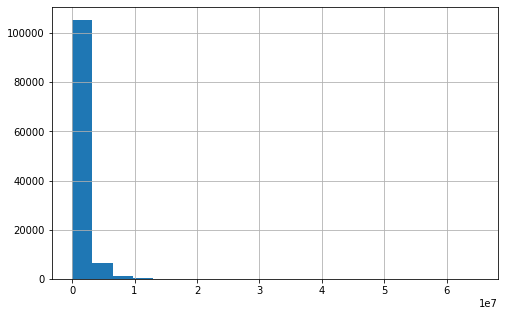

In [176]:
# посмотрим на распределение
train.price.hist(figsize=(8,5),bins=20);

Видно, что есть небольшое количество очень низких цен. В результате выборочной проверки нескольких ссылок выяснилось, что это ошибка при сборе данных - эти автомобили уже были проданы. Можно удалить эти экстремальные данные 

In [177]:
# Удалим из train и объединённого фрейма
train = train.drop(np.where(train['price'] < 10000)[0]) 
data = data.drop(np.where((data['price'] < 10000)&(data['sample']==1))[0]) 

In [178]:
# Проверяем
data[data['sample']==1].price.value_counts(ascending=True).sort_index()
# train[train.price < 10].price.value_counts()

12000.0       1
15000.0       2
18000.0       2
19000.0       1
19900.0       1
             ..
29000000.0    1
29800000.0    1
30850000.0    1
62500000.0    1
65000000.0    1
Name: price, Length: 7415, dtype: int64

за 12 тысяч продаётся реальный [автомобиль](https://auto.ru/cars/used/sale/nissan/bluebird/1104156088-92a6cd31/)

# NAIVE MODEL

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.

In [179]:
# снова выделим train и test из подготовленных на этом этапе данных
train = data[data['sample'] == 1].copy()
test = data[data['sample'] == 0].copy()

# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType','brand','color','engineDisplacement','enginePower',
            'fuelType','model_name','name','numberOfDoors','productionDate',
            'vehicleConfiguration','vehicleTransmission','Владельцы',
            'Привод','Руль']


df_train = train[columns]
df_test = test[columns]
y = train['price']

### Label Encoding

In [180]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_naiv = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [181]:
df_naiv.sample()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Привод,Руль,sample
50675,хэтчбек 5 дв.,NISSAN,чёрный,1.4 LTR,88 N12,бензин,NOTE,1.4 MT (88 л.с.),5,2010,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,2 владельца,передний,Левый,1


In [182]:
for colum in ['bodyType', 'brand', 'color', 'engineDisplacement']:
    df_naiv[colum] = df_naiv[colum].astype('category').cat.codes

In [183]:
X = df_naiv.query('sample == 1').drop(['sample'], axis=1)
X_sub = df_naiv.query('sample == 0').drop(['sample'], axis=1)

### Train Split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### Model 1

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [185]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [186]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 138.94%


# EDA

## PANDAS PROFILING

html доступен по ссылке

[report.html](https://drive.google.com/file/d/1FQpFLa1_nhmWpQqQdFsRrj5RVkcBMUCu/view?usp=sharing)



In [187]:
# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile.to_notebook_iframe() # развёрнутый вид
# profile.to_file("report.html") # в файл

## Категориальные признаки

### bodyType

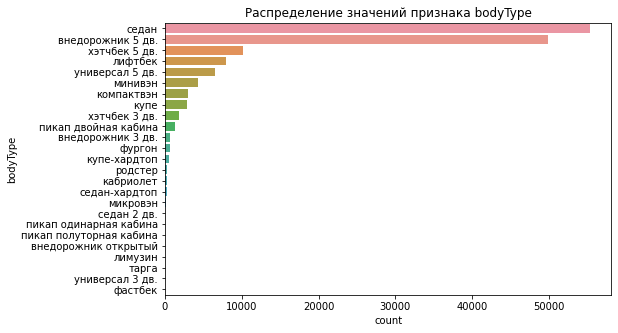

In [188]:
getCountPlot(data,'bodyType')

### brand

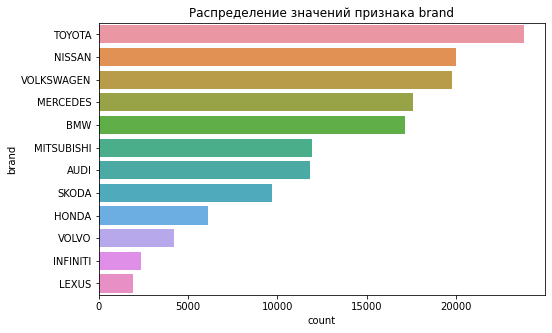

In [189]:
getCountPlot (data,'brand')

###  color

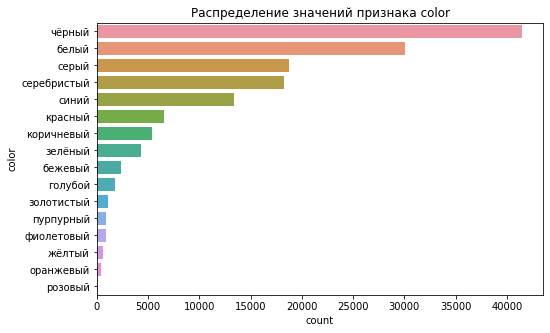

In [190]:
getCountPlot(data,'color')

### engineDisplacement

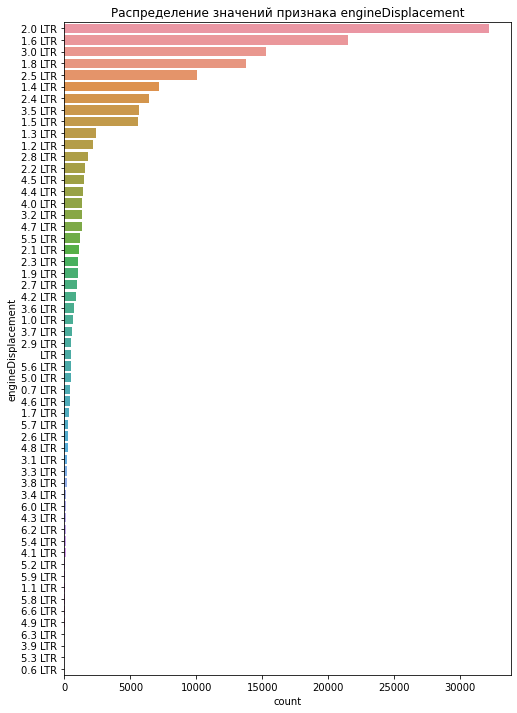

In [191]:
getCountPlot(data,'engineDisplacement',8,12)

Есть значение признака без указания объёма двигателя:

In [192]:
data[data['engineDisplacement']==' LTR'][['model_name', 'brand', 'fuelType']].value_counts()

model_name        brand       fuelType
LEAF              NISSAN      электро     409
I3                BMW         электро      55
E_TRON            AUDI        электро      13
I_MIEV            MITSUBISHI  электро      11
GOLF              VOLKSWAGEN  электро       9
EQC               MERCEDES    электро       6
MINICAB           MITSUBISHI  электро       6
EQV               MERCEDES    электро       5
NV200             NISSAN      электро       4
B_KLASSE          MERCEDES    электро       3
RS_E_TRON_GT      AUDI        электро       2
RAV_4             TOYOTA      электро       2
COMS              TOYOTA      электро       1
E_TRON_SPORTBACK  AUDI        электро       1
E_TRON_GT         AUDI        электро       1
E_TRON_S          AUDI        электро       1
BLUEBIRD_SYLPHY   NISSAN      электро       1
dtype: int64

Это электромобили

In [193]:
# очистим признак от ненужных букв и заменим пустые значения в электрокарах на 0

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 0 if x==' LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].astype(str).apply(lambda x: x.split()[0])
data['engineDisplacement'] = data['engineDisplacement'].astype(float)

### enginePower

In [194]:
data['enginePower'].unique()

array(['290 N12', '173 N12', '309 N12', '150 N12', '133 N12', '100 N12',
       '174 N12', '200 N12', '144 N12', '148 N12', '249 N12', '241 N12',
       '235 N12', '181 N12', '282 N12', '140 N12', '277 N12', '91 N12',
       '145 N12', '273 N12', '146 N12', '80 N12', '102 N12', '280 N12',
       '224 N12', '450 N12', '105 N12', '116 N12', '275 N12', '381 N12',
       '163 N12', '335 N12', '147 N12', '270 N12', '170 N12', '250 N12',
       '130 N12', '136 N12', '99 N12', '152 N12', '313 N12', '124 N12',
       '125 N12', '178 N12', '132 N12', '272 N12', '310 N12', '255 N12',
       '110 N12', '69 N12', '177 N12', '109 N12', '103 N12', '115 N12',
       '155 N12', '231 N12', '90 N12', '388 N12', '204 N12', '122 N12',
       '340 N12', '500 N12', '510 N12', '612 N12', '208 N12', '276 N12',
       '118 N12', '211 N12', '525 N12', '190 N12', '296 N12', '517 N12',
       '95 N12', '184 N12', '143 N12', '179 N12', '64 N12', '187 N12',
       '380 N12', '182 N12', '101 N12', '75 N12', '263 N12

In [195]:
# очистим
data['enginePower'] = data['enginePower'].str.replace(' N12', '')
data['enginePower'] = data['enginePower'].astype(int)

In [196]:
data['enginePower'].describe()

count    146323.000000
mean        176.597459
std          84.504326
min           7.000000
25%         116.000000
50%         152.000000
75%         211.000000
max         650.000000
Name: enginePower, dtype: float64

Так как мощность двигателя - дискретная величина, для дальнейшей обработки, разобьем на категории

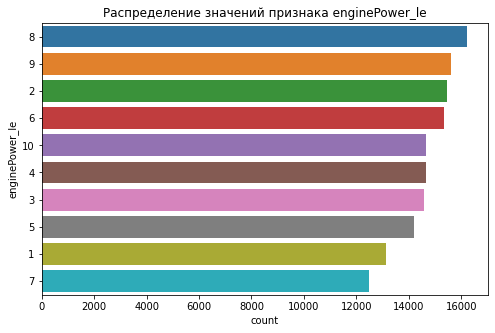

In [197]:
# разобьём всю последовательность значений на группы
# шаг приращения в np.arange - определяет количество итоговых групп (эспериментально)
gr = [np.percentile(data['enginePower'], i) for i in np.arange(0, 100, 10)]
data['enginePower_le'] = data['enginePower'].apply(lambda x: feature_to_cat(x, gr))
# sns.countplot(data=data, x="enginePower_le");
getCountPlot(data,'enginePower_le')

### fuelType

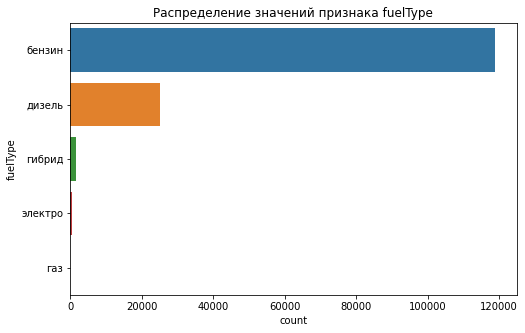

In [198]:
getCountPlot(data,'fuelType')

### modelDate

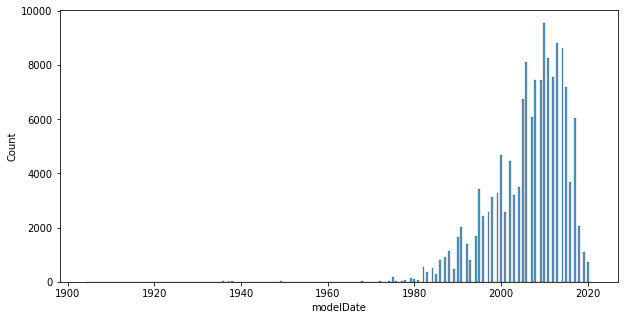

In [199]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="modelDate");

Больше всего в продаже 10-летних моделей

### numberOfDoors

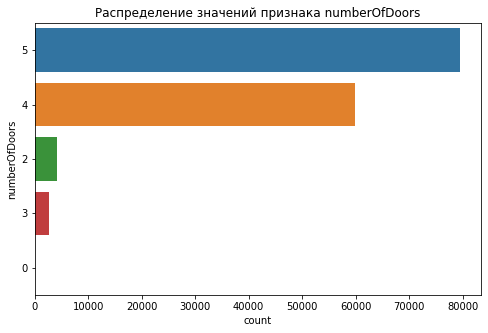

In [203]:
getCountPlot(data,'numberOfDoors')

у одного автомобиля указано 0 дверей

In [204]:
data[data['numberOfDoors'] == 0]

,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,enginePower_le
130271,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,5.3,32,бензин,48000,1904,SIMPLEX,5.3 MT (32 л.с.),0,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,Не требует ремонта,0.0,0,1


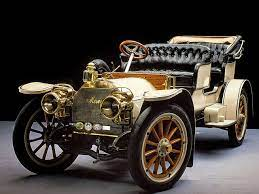

Вот такой, действительно - без окон, без дверей.

Этот автомобиль - явный эксклюзив, возможно стоит удалить его из выборки, но это позже - на этапе улучшения качества модели. Пока оставим под наблюдением.

### productionDate

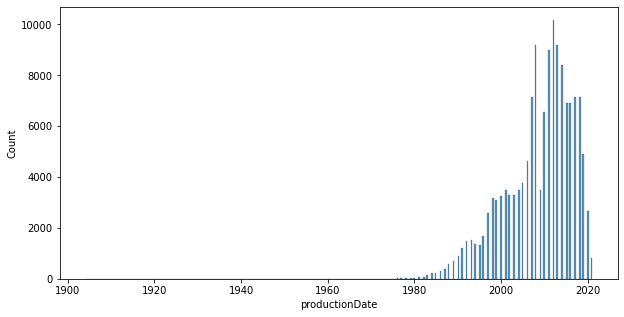

In [200]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="productionDate");

Почти копия modelDate

Вероятно будут сильно коррелировать - под наблюдение

In [207]:
data.drop(['vehicleConfiguration'], axis=1, inplace=True)

### vehicleTransmission

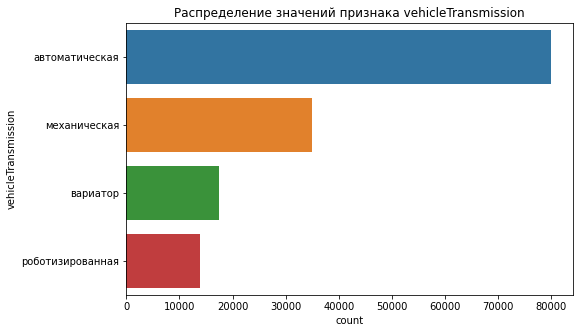

In [208]:
getCountPlot(data,'vehicleTransmission')

### super_gen

In [243]:
# Очень много уникальных наименований
data['super_gen'].nunique()

16703

In [245]:
# посмотрим на состав
data['super_gen'].value_counts()[:2]

{'id': '6214876', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'MECHANICAL', 'power': 105, 'power_kvt': 77, 'human_name': '1.6 MT (105 л.с.)', 'acceleration': 10.5, 'clearance_min': 170, 'fuel_rate': 6.5}    684
{'id': '20726520', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'AUTOMATIC', 'power': 110, 'power_kvt': 81, 'human_name': '1.6 AT (110 л.с.)', 'acceleration': 11.7, 'clearance_min': 163, 'fuel_rate': 5.9}    671
Name: super_gen, dtype: int64

Строки содержат как минимум 3 интересных числовых признака:

* acceleration
* clearance_min
* fuel_rate

Попробуем их извлечь

## Числовые признаки

### mileage

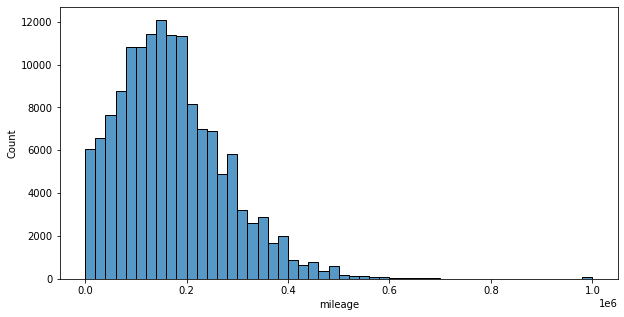

In [209]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['mileage'], bins=50);

Есть автомобили с пробегом под 1 млн. километров. Посмотрим на них

In [210]:
data[data['mileage']>999999][['brand', 'mileage','Состояние']].value_counts()

brand       mileage  Состояние         
TOYOTA      1000000  Не требует ремонта    7
VOLKSWAGEN  1000000  Не требует ремонта    6
MERCEDES    1000000  Не требует ремонта    5
BMW         1000000  Не требует ремонта    5
NISSAN      1000000  Не требует ремонта    3
AUDI        1000000  Не требует ремонта    3
TOYOTA      1000000  Требует ремонта       2
VOLVO       1000000  Не требует ремонта    1
VOLKSWAGEN  1000000  Требует ремонта       1
NISSAN      1000000  Требует ремонта       1
MITSUBISHI  1000000  Не требует ремонта    1
MERCEDES    1000000  Требует ремонта       1
HONDA       1000000  Не требует ремонта    1
BMW         1000000  Требует ремонта       1
dtype: int64

Удивительно, конечно, что автомобиль с пробегом 1 млн килорметров "не требует ремонта", но проверка показала, что именно так и указано в объявлении, при том, что в описании часто перечислены значительные неисправности... 

И хотя пробег возможно и реальный, но лучше считать это выбросом и удалить. Таких значений не много.

Посмотрим на распределение признака внутри межквартильного размаха

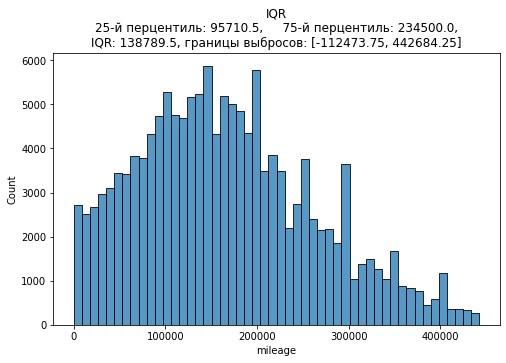

In [211]:
interquartile_range(data['mileage'], bins=50)

Распределение в целом нормальное.
Любопытны аномальные выбросы вблизи "круглых" значений пробега - 150, 200, 250, 300, 350, 400 тысяч километров.

Может свидетельствовать о наличии в этих группах определённой доли автомобилей с "нечестным" пробегом.

Можно попробовать создать признак на основе этой информации....

In [212]:
# заменим выбросы на медиану
emission_replacement(data,'mileage', method='median')

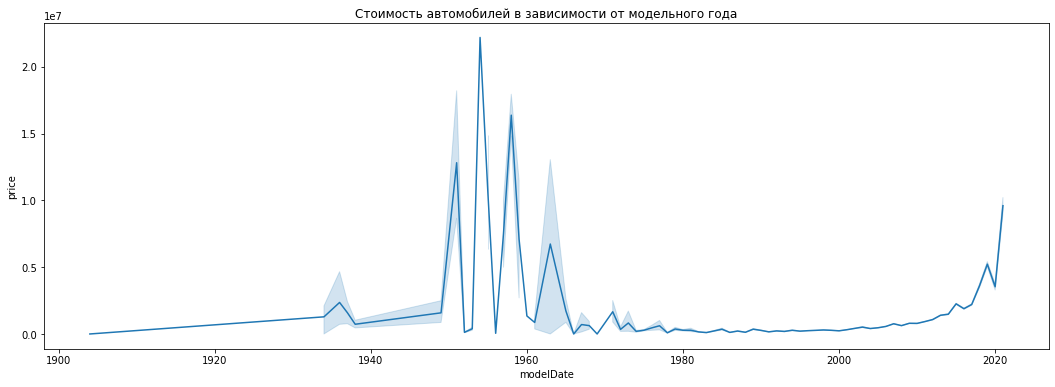

In [213]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(data=data, x='modelDate', y="price");
plt.title(f'Стоимость автомобилей в зависимости от модельного года');

In [214]:
# column = list(data.columns)
# for col in column:
#     try:
#         getCountPlot(data,col)
#     except:
#         print(f'Не поддерживается {col}')

## Признаки для возможной векторизации

* model_name
* name
* description
* vehicleConfiguration



### model_name

In [201]:
# Очень много уникальных наименований
data['model_name'].nunique()

673

In [202]:
# список ТОП-50 
data['model_name'].value_counts()[:50]

OCTAVIA               4615
5ER                   4035
POLO                  3834
PASSAT                3730
CAMRY                 3712
E_KLASSE              3535
3ER                   2959
LANCER                2879
TIGUAN                2773
COROLLA               2763
QASHQAI               2632
X5                    2581
A6                    2575
X_TRAIL               2563
RAV_4                 2472
LAND_CRUISER          2350
OUTLANDER             2238
TOUAREG               2000
C_KLASSE              1996
A4                    1954
S_KLASSE              1910
LAND_CRUISER_PRADO    1908
ALMERA                1848
GOLF                  1807
RAPID                 1637
JETTA                 1422
X6                    1360
PAJERO                1353
M_KLASSE              1349
X3                    1265
7ER                   1224
CIVIC                 1211
PRIMERA               1149
Q7                    1141
TEANA                 1094
ACCORD                1056
CR_V                  1049
F

### vehicleConfiguration

In [205]:
# Очень много уникальных наименований
data['vehicleConfiguration'].nunique()

824

In [206]:
# список ТОП-50 
data['vehicleConfiguration'].value_counts()[:50]

ALLROAD_5_DOORS AUTOMATIC 3.0       9889
SEDAN AUTOMATIC 2.0                 7061
SEDAN MECHANICAL 1.6                6451
ALLROAD_5_DOORS AUTOMATIC 2.0       5784
ALLROAD_5_DOORS VARIATOR 2.0        5655
SEDAN AUTOMATIC 2.5                 4175
SEDAN AUTOMATIC 1.6                 4136
SEDAN AUTOMATIC 3.0                 3170
SEDAN MECHANICAL 1.8                2885
SEDAN AUTOMATIC 1.8                 2796
ALLROAD_5_DOORS AUTOMATIC 3.5       2291
SEDAN MECHANICAL 2.0                2265
SEDAN AUTOMATIC 2.4                 2246
LIFTBACK MECHANICAL 1.6             1995
ALLROAD_5_DOORS ROBOT 2.0           1886
ALLROAD_5_DOORS AUTOMATIC 2.5       1863
SEDAN AUTOMATIC 3.5                 1555
ALLROAD_5_DOORS AUTOMATIC 4.5       1415
LIFTBACK AUTOMATIC 1.6              1314
ALLROAD_5_DOORS AUTOMATIC 2.4       1299
SEDAN AUTOMATIC 1.5                 1280
ALLROAD_5_DOORS MECHANICAL 2.0      1254
ALLROAD_5_DOORS VARIATOR 3.5        1135
HATCHBACK_5_DOORS MECHANICAL 1.4    1099
ALLROAD_5_DOORS 

признак дублирует обобщенную информацию из других признаков. обработать крайне сложно. удалим его

### name

In [219]:
# Очень много уникальных наименований
data['name'].nunique()

4475

In [220]:
# список ТОП-50 
data['name'].value_counts()[:50]

1.6 AT (110 л.с.)               2664
1.6 MT (102 л.с.)               1675
2.5 AT (181 л.с.)               1622
1.6 MT (110 л.с.)               1536
1.6 MT (105 л.с.)               1411
1.4 AMT (150 л.с.)              1315
2.0 CVT (146 л.с.) 4WD          1312
1.6 MT (90 л.с.)                1283
2.0 CVT (144 л.с.) 4WD           975
2.0 CVT (141 л.с.) 4WD           974
1.4 AMT (122 л.с.)               969
1.6 MT (98 л.с.)                 959
1.8 MT (90 л.с.)                 940
1.6 AT (105 л.с.)                905
1.6 CVT (117 л.с.)               887
30d 3.0d AT (249 л.с.) 4WD       863
1.8 AMT (152 л.с.)               804
35i 3.0 AT (306 л.с.) 4WD        796
4.5d AT (235 л.с.) 4WD           762
1.6 AT (102 л.с.)                741
2.0 AT (170 л.с.) 4WD            710
3.5 CVT (249 л.с.) 4WD           695
1.6 MT (107 л.с.)                666
1.5 AT (105 л.с.)                658
350 3.5 AT (272 л.с.) 4WD        638
2.0 CVT (144 л.с.)               636
2.0 AT (150 л.с.)                604
1

Признак можно было бы подвергнуть векторизации, но пока удалим.

In [240]:
# from sklearn.feature_extraction.text import CountVectorizer
# # Создаём объект, который будет токенизировать данные
# # analyzer = CountVectorizer(stop_words='english').build_analyzer()

# # Создаём объект, который будет токенизировать данные
# vectorizer = CountVectorizer(stop_words='english', max_features = 100)
# v = vectorizer.fit_transform(data['name'])
# # Токенизируем набор данных
# ft = vectorizer.get_feature_names()
# m = vectorizer.transform(data['name'])

In [241]:
# резреженная матрица
# m.shape

(146323, 100)

In [231]:
# m

<146323x736 sparse matrix of type '<class 'numpy.int64'>'
	with 431571 stored elements in Compressed Sparse Row format>

In [242]:
# # обычный массив
# m.toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [215]:
data.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'super_gen',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'price', 'sample', 'enginePower_le'],
      dtype='object')

# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 